# <center><font color=maroon>EE6670: Final Project:  Electromyogram Signal Analysis with Neural Networks for Hand Gesture Detection</font></center>


# <center> By Timothy J. Marchant </center>

In this file I detail two of my models since it is relevant for this project.  My Ideal model is one I had worked towards for several weeks so I want to present it.  I also have the actual model I deployed.  I unfortunately learned too late (I was focusing too much on getting a perfect model) I was limited to 32KB of SRAM or when I compile the model around 64kb for the model size.

<center>Dataset setup</center>

Also, this project contains everything needed to clean the data and run the models (I think on a Mac that will take a long time).  The only thing that this is missing is moving the dataset to a new folder I named "Unlabeled_Data".  To do this download the dataset linked here http://dx.doi.org/10.17632/ckwc76xr2z.2, it should give you a file named "ckwc76xr2z-2".  Go into that file, go into sEMG-dataset, then filtered, then csv.  Copy the csv folder into Unlabeled_Data and you should be good.

This the directory structure should be like this: ckwc76xr2z-2/sEMG-dataset/filtered/csv.  After this make a new folder called "Unlabeled_Data" and move the csv folder into it and then you're good.

There is also an excel file that tells you some information about the subjects.  This includes things like weight, gender, and height.  The dataset is split 50-50 men and women.  There are other files, but I only used the ones mentioned above.

Lastly, make sure to use the python envoirment I named "env".  by the way this is ran in VSCode.

In [21]:
###Necessary libraries to import.

import tensorflow as tf
from tensorflow import keras
import scipy
from scipy import integrate
from scipy import signal
import numpy as np
import csv
import os
import sys
import enum
from enum import Enum
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Normalization
from keras.layers import LayerNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model


Versions of libraries I am using.  I am also running this on my linux desktop.

In [23]:
print(np.__version__)
print(tf.__version__)  ###Nightly build.  2.20 doesn't support the 50 series gpus.
print(sys.version)

1.26.4
2.21.0-dev20251205
3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]


Enum definitions for constants relating to the dataset for labeling.

In [29]:
class EMG_Gestures(Enum):
    #gestures are also performed in this order.
    Rest=0
    Extension=1
    Flexion=2
    UlnarDeviation=3
    RadialDeviation=4
    Grip=5
    Abduction=6
    Adduction=7
    Supination=8
    Pronation=9
    NumOfSubjects=40 #40 subjects total
    SubjectDataSize=1280000 #Total number of rows with data.
    TOTALDATASETSIZE=51200000 #All data combined.  There's this many rows.
    NumOfChannels=4
class DataSetTimings(Enum):
    #time units are half milliseconds since our sampling frequency is 2000 hz.
    CycleLength=(104*1000*2) ##104 seconds in half milliseconds
    ModifiedCycleLength=(64*1000*2)
    NumOfCycles=5 ##5 cycles total.
    RestingCycleLegth=30000*2 ##30 seconds in half milliseconds
    SamplingRate=2000 #2000hz.  Records are 0.5 ms apart
    SkipLength=CycleLength-ModifiedCycleLength
    #all of these are in one cycle.  All are in half milliseconds
    GestureTime=6000*2 #6 seconds was for each specific gesture
    RestTime=4000*2 #4 seconds in half milliseconds for resting between gestures
    StayAbduction=8 #8th rest period stay in abduction
    StaySupination=9 #same as above but for supination starts at last iteration, that is i=9.

We need to extract data from the dataset.  To do this we will take the filtered csv files from ozdemir et al.

In [ ]:

datasetptr=0

def AssignDataALabel(csvwriter,data,Label):
    global datasetptr
    row=[0.0,0.0,0.0,0.0,0]
    for i in range(0,EMG_Gestures.NumOfChannels.value):
        row[i]=data[i]
    row[4]=Label
    csvwriter.writerow(row)
    datasetptr+=1
def LabelForLoop(writer,Time,Label,Dataset):
    global datasetptr
    for j in range(0,Time):
        AssignDataALabel(writer,Dataset[datasetptr],Label)
def WriteNewLabeledCSV(file,outputpath):
    global datasetptr
    firstsplitstring=file.split('/')
    splitstring=firstsplitstring[-1].split('.',1)
    newfile=outputpath
    newfile+=splitstring[0]
    newfile+="_Labeled.csv"
    Dataset=np.loadtxt(file,delimiter=",",dtype=float)
    with open (newfile, 'w',newline='') as csvfile:
        writer=csv.writer(csvfile,delimiter=',')
        for Cycle in range(0,DataSetTimings.NumOfCycles.value): 
            for i in range(EMG_Gestures.Rest.value,EMG_Gestures.Grip.value+1):
                ##REST PERIOD
                if (Cycle!=0 or (Cycle==0 and i!=0)): ##Skip first rest period. There are outliers in it.
                    LabelForLoop(writer,DataSetTimings.RestTime.value,EMG_Gestures.Rest.value,Dataset)
                else:
                    datasetptr+=DataSetTimings.RestTime.value
                ##GESTURE PERIOD
                LabelForLoop(writer,DataSetTimings.GestureTime.value,i,Dataset)
            LabelForLoop(writer,DataSetTimings.RestTime.value,EMG_Gestures.Rest.value,Dataset)
            datasetptr+=DataSetTimings.SkipLength.value
            #Large rest period
            if (Cycle!=DataSetTimings.NumOfCycles.value-1):
                #LabelForLoop(writer,DataSetTimings.RestingCycleLegth.value,EMG_Gestures.Rest.value,Dataset)
                datasetptr+=DataSetTimings.RestingCycleLegth.value
            
    datasetptr=0


In [31]:
fname='LabeledEMGData'

Datasetpath="Unlabeled_Data/"
OutputPath="Train"

if (os.path.exists(fname)==False):
    os.mkdir(fname)
PathToData=Datasetpath+"csv/"
PathToOutput=fname+"/"
OutputPath=PathToOutput+OutputPath

if (os.path.exists(OutputPath)==False):
    os.mkdir(OutputPath)
OutputPath+="/"
print(OutputPath)

LabeledEMGData/Train/


Label the data this took a little more than a minute on my machine using a i7 14th gen desktop.

In [32]:

##1 = 30s rest period marked 0 = default rest period marked normally.

CSVFiles=os.listdir(PathToData)
def LabelData(PathToData,CSVFileList,PathToOutput):
    for csvfile in CSVFileList:
        WriteNewLabeledCSV(PathToData+csvfile,PathToOutput)
print("Starting")
LabelData(PathToData, CSVFiles, OutputPath)
print("Finished")


print("End")

Starting
Finished
End


We can now graph some of the data (unlabeled)

Subject 13 EMG data; small window


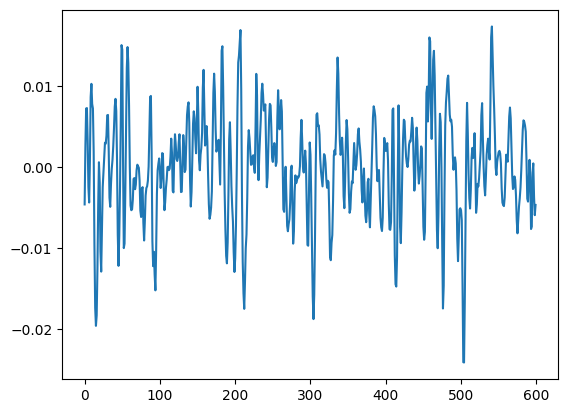

Subject 3 EMG data


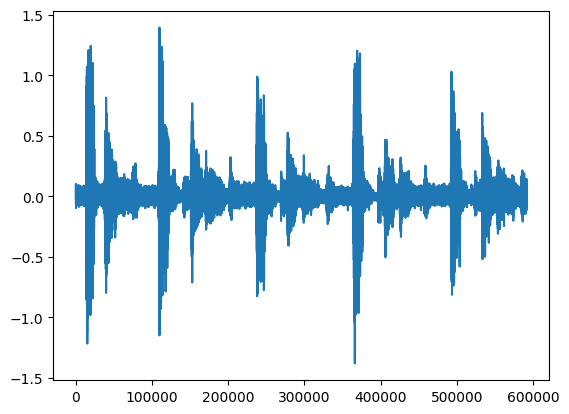

Rectified


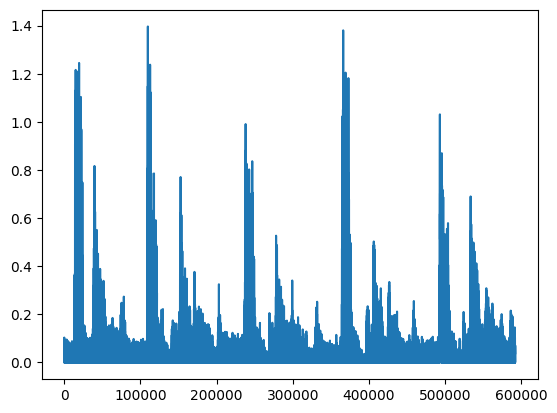

Labeled (poorly)


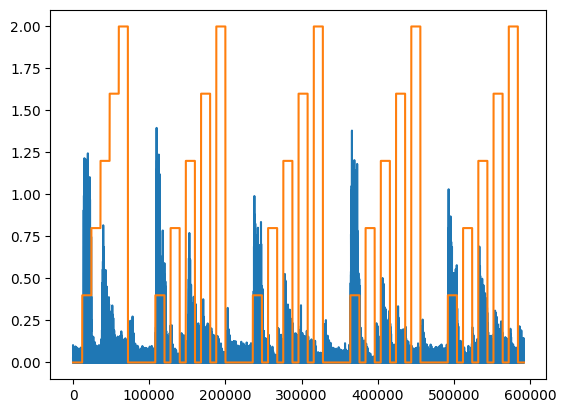

In [43]:
##Graph data
EMGData=np.loadtxt(fname=OutputPath+"13_filtered_Labeled.csv",delimiter=',', usecols=(0,1,2,3,4))
EMGData2=np.loadtxt(fname=OutputPath+"3_filtered_Labeled.csv",delimiter=',', usecols=(0,1,2,3,4))

Datalen=np.shape(EMGData)[0]

x=np.linspace(0,Datalen,Datalen)

print("Subject 13 EMG data; small window")
plt.plot(x[0:600],EMGData[28000:28600,0])  ##Only show one channel with labels.
plt.show()
print("Subject 3 EMG data")
plt.plot(x,EMGData2[0:Datalen,0])  ##Only show one channel with labels.
plt.show()
print("Rectified")
EMGData2=np.abs(EMGData2)
plt.plot(x,EMGData2[0:Datalen,0])
plt.show()
print("Labeled (poorly)")
EMGData2[0:,4]*=0.4 ##Scale down labels
plt.plot(x,EMGData2[0:,0:5:4])

The bars above represent the class for that part of the signal.  Unfortunately in my code I screwed up the labeling process.  I meant to remove the first 4 seconds of the data.  It seems that I removed more than that.

These two sections are for combining the entire dataset into one file.  First define the input and output path.  And then label the data.

In [34]:
ftrain="Train_EMG_Data"
ModelDataOutputPath='ModelData'
Trainfolder="LabeledEMGData/Train/"



In [35]:

def CombineCSVFiles(InputPath, OutputPath, fname):
    if (os.path.exists(OutputPath)==False):
        os.mkdir(OutputPath)

    CSVFILE=OutputPath+"/"+fname+".csv"

    files=os.listdir(InputPath)
    files.sort()
    with open(CSVFILE,"w",newline='') as csvfile:
        writer=csv.writer(csvfile,delimiter=',',quoting=csv.QUOTE_NONE)  
        for file in files:
            Dataset=np.loadtxt(InputPath+file,delimiter=',',dtype=object)  ##Load one file in
            writer.writerows(Dataset)  ##Write that data into a larger CSV file
            print(file+" Finished writing")  ##Track progress
print("Starting")
print("Train data")
CombineCSVFiles(Trainfolder,ModelDataOutputPath,ftrain)
print("Finished")


Starting
Train data
10_filtered_Labeled.csv Finished writing
11_filtered_Labeled.csv Finished writing
12_filtered_Labeled.csv Finished writing
13_filtered_Labeled.csv Finished writing
14_filtered_Labeled.csv Finished writing
15_filtered_Labeled.csv Finished writing
16_filtered_Labeled.csv Finished writing
17_filtered_Labeled.csv Finished writing
18_filtered_Labeled.csv Finished writing
19_filtered_Labeled.csv Finished writing
1_filtered_Labeled.csv Finished writing
20_filtered_Labeled.csv Finished writing
21_filtered_Labeled.csv Finished writing
22_filtered_Labeled.csv Finished writing
23_filtered_Labeled.csv Finished writing
24_filtered_Labeled.csv Finished writing
25_filtered_Labeled.csv Finished writing
26_filtered_Labeled.csv Finished writing
27_filtered_Labeled.csv Finished writing
28_filtered_Labeled.csv Finished writing
29_filtered_Labeled.csv Finished writing
2_filtered_Labeled.csv Finished writing
30_filtered_Labeled.csv Finished writing
31_filtered_Labeled.csv Finished writin

Constants for the data.  300ms window and 75ms increment.  I found that this just worked the best.

In [36]:
SlidingWindowWidth=300*2 #*2 To adjust to the correct time units. E.G. 600 = 300 milliseconds since our sampling rate was 2000hz.
SlidingWindowIncrement=75*2
NumberOfChannels=4
NumberOfGestures=6
DataPath="ModelData/Train_EMG_Data.csv"

This function paritions windows and allows us to input them into the model.  Each window is assigned one label.  The label corresponds to the rightmost sample in the window.

In [37]:
def GetSlidingWindowArrays(Path):
    global SlidingWindowWidth
    global SlidingWindowIncrement
    global NUMOFFEATURES
    global NumberOfChannels
    HighestIndexOffset=SlidingWindowWidth//SlidingWindowIncrement
    Dataset=np.loadtxt(Path,delimiter=',',dtype=float,usecols=(0,1,2,3,4))
    Dataset=np.absolute(Dataset)
    Size=np.shape(Dataset)[0]
    WindowArray=np.zeros(shape=(SlidingWindowWidth,NumberOfChannels),dtype=float)
    Totalsequences=int((Size-SlidingWindowWidth)/SlidingWindowIncrement-HighestIndexOffset) #Actual numbers if features that need to be computed
    LabelArray=np.zeros(shape=(Totalsequences),dtype=int)
    SlidingWindowsArray=np.zeros(shape=(Totalsequences, SlidingWindowWidth, NumberOfChannels))
    print(np.shape(WindowArray))
    print(np.shape(SlidingWindowsArray))
    LABELINDEX=-1
    for i in range (0,Totalsequences):
        FarthmostPTR=SlidingWindowIncrement*i+SlidingWindowWidth
        WindowArray=Dataset[SlidingWindowIncrement*i:FarthmostPTR,0:NumberOfChannels]
        LabelArray[i]=int(Dataset[FarthmostPTR,LABELINDEX]) ##Get right most position for current label.
        SlidingWindowsArray[i]=WindowArray

    return SlidingWindowsArray, LabelArray

WindowArray,LabelArray=GetSlidingWindowArrays(DataPath)

(600, 4)
(157858, 600, 4)


We can draw a labeled version as well

Normalization code.  I took this from HW4.  I used zscore since it worked well in the past.  I tried a simple linear scaling and it doesn't work very well.  It should also be noted that most of the data is really small e.g. less than 1 millivolt.  So Zscore is very good for that since nonrest gestures are considered "abnormal" e.g. outside of the ususal range.
Also I tried log transforming the data which helps (just make sure to add by a small constant) but the difference isn't that noticeable.  However, it is not practical to compute the log of 2400 floats and then take the zscore on a MCU.

In [10]:
def zscore_normalize(X):

    mu = np.mean(X, axis=0)        # find the mean of each column/feature          
                                    
    sigma  = np.std(X, axis=0)     # find the standard deviation of each column/feature            

    X = (X - mu) / sigma           # Normalize each column wrt its mean and std

    return X

In [11]:

Y=tf.keras.utils.to_categorical(LabelArray,num_classes=NumberOfGestures)
X=zscore_normalize(WindowArray)

Split the data

In [12]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.25, random_state=101)

The ideal model
There are six 1d convolutional layers (gelu was the activation function; just performed the best), 4 average pooling layers, and then the output dense layer (obviously softmax).  I first start with a smaller number of filters and then increase from there pooling size increases at the end to reduce model size.  One Exception was for the fourth convolutional layer were I set kernel size to 48 for n4.  This was to reduce model size.  This was meant for an embedded platform so we have to keep that in mind.  Also the TFLITE file was only 100kb after quantization.  
Some other notes.  

First layer I set strides=2 and kernel size=2.  Setting stride to that decrease model training time.  I learned this when I tried a multi input model where I put each channel as an input.  Unfortunately that model turned out worse than this one.  Also I just played with kernel sizing and left this one at 2.  I noticed that smaller kernels are better at lower layers.  

Second layer kernelsize=3.  Just increased size not anything special.  

Third layer Average pooling layer: Tried both pool size=2 and 3.  2 worked better.  

Fourth layer: Same as 2  

Fifth layer: average pooling layer: same as previous one.  

Sixth layer: another convolutional layer same as 2.  

Seventh layer: Same as before, but a larger kernel size.  I found that larger kernels worked better in later layers for whatever reason.  

Eighth layer: Average pooling layer: This one is different I used pool size=3.  This worked better at this stage.  Also it reduced model size  

Ninth layer: Same as seventh.  

tenth layer: Dropout layer.  Set to 0.5 since it gave the best results.  Earlier layers do not have dropout as it degraded accuracy a lot. 

Eleventh layer: Average pooling layer: Same as the previous pooling layer.  Pool size=3 gave better results.  

Flatten: Reshape convolutional output  

Output Layer: Take the convolutional input and make a decision here.  No other dense layers as adding more gave worse results and increased size.  

Also all these use L2 regularization.  So originally I was using 0.00001 as the value for that (too large values caused problems in the past), but changed it to 0.0001.  I guess I never updated the output layer's regularization value.

In [13]:
n1=32
n2=48
n3=64
n4=48
n5=64
n6=128
keras.utils.set_random_seed(777)  ###I used this seed in each model.  Maybe 777 wasn't my lucky number.

In [80]:

Model=Sequential()

Model.add(Conv1D(n1,input_shape=(SlidingWindowWidth,NumberOfChannels),strides=2,kernel_size=2,activation="gelu",kernel_regularizer=keras.regularizers.l2(0.0001)))
Model.add(Conv1D(n2,kernel_size=3,activation="gelu",kernel_regularizer=keras.regularizers.l2(0.0001)))


Model.add(AveragePooling1D(pool_size=2))

Model.add(Conv1D(n3,kernel_size=3,activation="gelu",kernel_regularizer=keras.regularizers.l2(0.0001)))

Model.add(AveragePooling1D(pool_size=2))
Model.add(Conv1D(n4,kernel_size=3,activation="gelu",kernel_regularizer=keras.regularizers.l2(0.0001)))

Model.add(Conv1D(n5,kernel_size=5,activation="gelu",kernel_regularizer=keras.regularizers.l2(0.0001)))
Model.add(AveragePooling1D(pool_size=3))
Model.add(Conv1D(n6,kernel_size=5,activation="gelu",kernel_regularizer=keras.regularizers.l2(0.0001)))
Model.add(Dropout(0.5))
Model.add(AveragePooling1D(pool_size=3))

Model.add(Flatten())

Model.add(Dense(NumberOfGestures,activation="softmax",kernel_regularizer=keras.regularizers.l2(0.00001)))
Model.summary()



/home/timothy/Documents/VSCode_Workspace/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 300, 32)        │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 298, 48)        │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_12            │ (None, 149, 48)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 147, 64)        │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_13            │ (None, 73, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 71, 48)         │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 67, 64)         │        15,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_14            │ (None, 22, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 18, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_15            │ (None, 6, 128)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         4,614 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,614 (330.52 KB)

 Trainable params: 84,614 (330.52 KB)

 Non-trainable params: 0 (0.00 B)

Adam was used for the optimizer with a learning rate of 0.0001 and clipnorm=10.  I tried multiple clipnorm values and also weight decay.  I found that these were just the best values by trial and error.  Also higher learning rate caused accuracy problems so I stuck to 0.0001.

In [81]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Create the ModelCheckpoint callback. The best model is saved in H5 format.
checkpoint = ModelCheckpoint('best_model_CNNgelu2.keras', monitor='val_accuracy', save_best_only=True, verbose = 0)

Optimizer = keras.optimizers.Adam(learning_rate=0.0001,clipnorm=10)

Model.compile(loss="categorical_crossentropy", optimizer=Optimizer, metrics=["accuracy"])

The model takes 2ms per step and there are 1619 steps per epoch

1500 epochs.  I found that this many epochs were really needed to tell a difference between models.  I believe with some of these if you trained them longer you could get slightly better results, but that takes a long time.  I ran one of these models one time for 10000 epochs and it took like 6 hours.  Obviously that one did not make the cut.  Also I am running this on a 5060 TI 16GB GPU.  So I have no clue how long this takes to run on a laptop cpu.

In [82]:
history = Model.fit(X_Train, Y_Train, epochs=1500, steps_per_epoch=None, batch_size = 64, validation_split=0.125, verbose = 0 ,
                    callbacks=[checkpoint]
                    )

The code for the graphs and such I took from our homework

In [83]:
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]   
valid_acc  = history.history["val_accuracy"]
print (f"The accuracy for the Train Data = {train_acc[-1]*100 :.2f}%")

print (f"The accuracy for the Validation Data = {valid_acc[-1]*100 :.2f}%")

The accuracy for the Train Data = 96.72%
The accuracy for the Validation Data = 91.74%


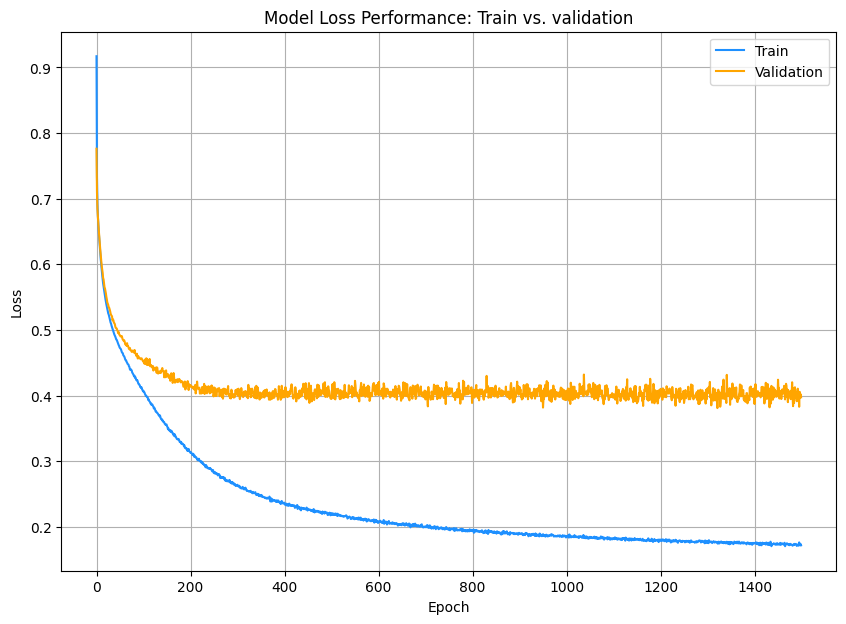

In [84]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

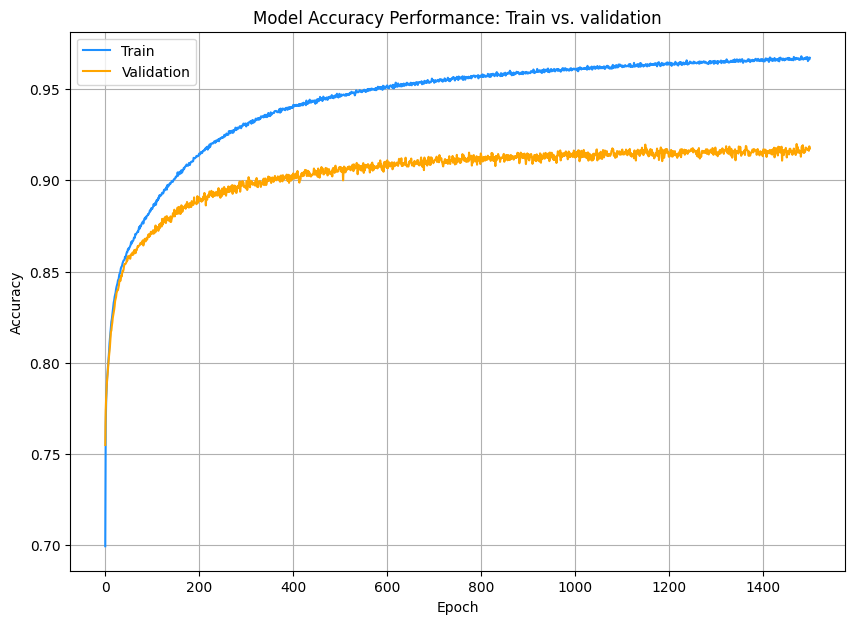

In [85]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [ ]:
##Test accuracy
lossfinal,Test_Accuracy=Model.evaluate(X_Test,Y_Test,verbose=1)

print(f"Test accuracy= {Test_Accuracy*100 :.2f}%")

# Load the best model
best_model = load_model('best_model_CNNgelu2.keras')
loss, accuracy = best_model.evaluate(X_Test, Y_Test,verbose=1)

print(f"Test Data Loss: {loss: .4f}")
print(f"Test Data Accuracy: {accuracy*100: .2f}%")

1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9176 - loss: 0.3957
Test accuracy= 91.76%
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9181 - loss: 0.3973
Test Data Loss:  0.3973
Test Data Accuracy:  91.81%


The confusion matrix shows that for the most part the model identifies everything pretty close to each gesture.  I'd imagine the error might come from transistions.  I followed an example (I think stack overflow; made this months ago) for printing the confusion matrix.

1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step
(6, 6)


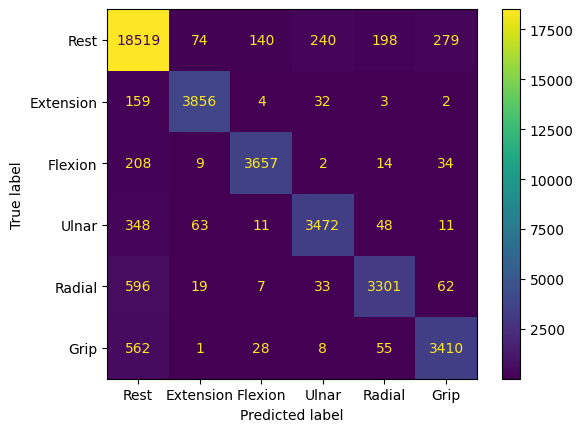

In [87]:
#Create confusion matrix and normalizes it over predicted (columns)
#Predict
indexes=[0,1,2,3,4,5]  ###Corresponds to the gestures from rest, extension, flexion, ulnar, radial, and grip.
y_test_predictions=np.argmax(Model.predict(X_Test),axis=1)
Y_Test_True=np.argmax(Y_Test,axis=1)
Confusion = confusion_matrix(Y_Test_True, y_test_predictions , labels=indexes)
print(np.shape(Confusion))
dis=ConfusionMatrixDisplay(Confusion,display_labels=("Rest","Extension","Flexion","Ulnar","Radial","Grip"))
dis.plot()
plt.show()

MCU Model

I found that the last layer plays the most important role in terms of actual performance.  I'm guessing it has to do with obtaining the more complex features that are only seen later in the model.
In this model I dropped two of the pooling layers and two convolutional layers.  But I made the stride different.  In each convolutional layer I set strides=2.  Not only does this reduce size, but dramatically decreases training time.  I also noticed it gives similiar results to a pooling layer. I also swapped gelu to relu for compatiability reasons.  Also last layer and first layer kernel size is set to 3.  This gave better results in my short amount of time training these new models.

This model is better than the one I presented.  It's not by much in test accuracy, but a better inference time of 37.3ms.  It actually didn't take that much more space either.

I did not change anything else other than the epoch count is set to 2500 and batchsize to 256.

In [109]:
m1=24
m2=24
m3=28
m4=80


In [110]:

Model_MCU=Sequential()

Model_MCU.add(Conv1D(m1,input_shape=(SlidingWindowWidth,NumberOfChannels),strides=2,kernel_size=3,activation="relu",kernel_regularizer=keras.regularizers.l2(0.0001)))

Model_MCU.add(Conv1D(m2,kernel_size=3,activation="relu",strides=2,kernel_regularizer=keras.regularizers.l2(0.0001)))
Model_MCU.add(Conv1D(m3,kernel_size=3,activation="relu",strides=2,kernel_regularizer=keras.regularizers.l2(0.0001)))

Model_MCU.add(AveragePooling1D(pool_size=2))
Model_MCU.add(Conv1D(m4,kernel_size=3,activation="relu",strides=2,kernel_regularizer=keras.regularizers.l2(0.0001)))

Model_MCU.add(AveragePooling1D(pool_size=3))
Model_MCU.add(Dropout(0.5))


Model_MCU.add(Flatten())

Model_MCU.add(Dense(NumberOfGestures,activation="softmax",kernel_regularizer=keras.regularizers.l2(0.00001)))
Model_MCU.summary()

/home/timothy/Documents/VSCode_Workspace/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 299, 24)        │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 149, 24)        │         1,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 74, 28)         │         2,044 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_18            │ (None, 37, 28)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 18, 80)         │         6,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_19            │ (None, 6, 80)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         2,886 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,794 (53.88 KB)

 Trainable params: 13,794 (53.88 KB)

 Non-trainable params: 0 (0.00 B)

Same as before minus a larger batch size and epoch count.

In [111]:
# Create the ModelCheckpoint callback. The best model is saved in H5 format.
checkpoint = ModelCheckpoint('best_model_1dCNN_MCU.keras', monitor='val_accuracy', save_best_only=True, verbose = 0)

Optimizer = keras.optimizers.Adam(learning_rate=0.0001,clipnorm=10)

Model_MCU.compile(loss="categorical_crossentropy", optimizer=Optimizer, metrics=["accuracy"])

When I ran with verbose it claims about 2ms per step over 405 steps.

In [112]:
history = Model_MCU.fit(X_Train, Y_Train, epochs=2500, steps_per_epoch=None, batch_size = 256, validation_split=0.125, verbose = 0,
                    callbacks=[checkpoint]
                    )

These next sections are like the previous part.

In [113]:
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
print (f"The accuracy for the Train Data = {train_acc[-1]*100 :.2f}%")

print (f"The accuracy for the Validation Data = {valid_acc[-1]*100 :.2f}%")

The accuracy for the Train Data = 87.96%
The accuracy for the Validation Data = 87.54%


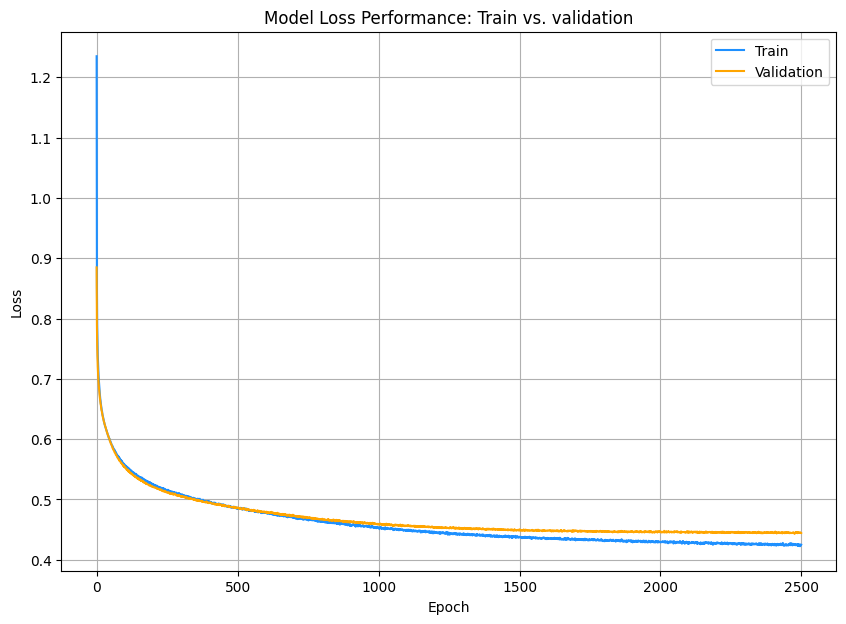

In [114]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

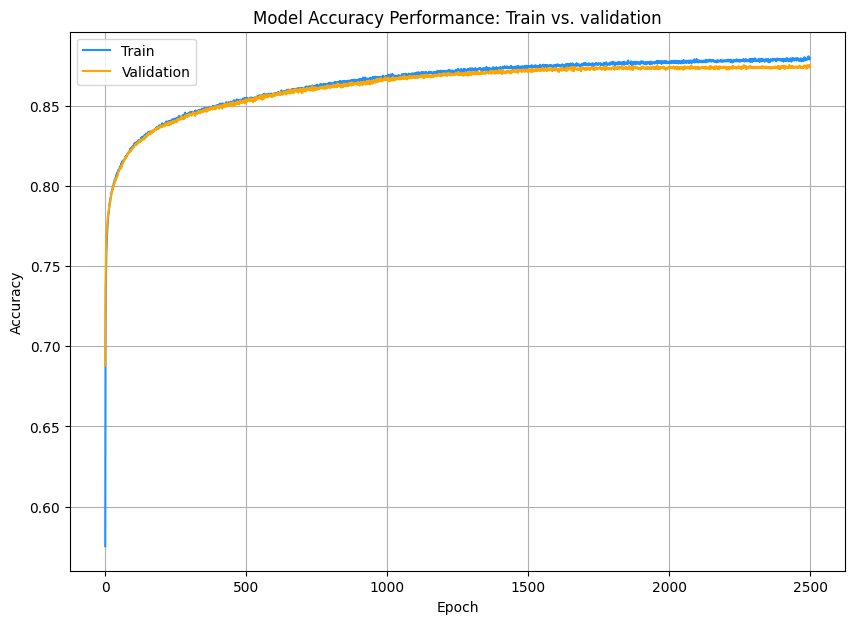

In [115]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [116]:
##Test accuracy
lossfinal,Test_Accuracy=Model_MCU.evaluate(X_Test,Y_Test,verbose=1)

print(f"Test accuracy= {Test_Accuracy*100 :.2f}%")
# Load the best model
best_model = load_model('best_model_1dCNN_MCU.keras')
loss, accuracy = best_model.evaluate(X_Test, Y_Test,verbose=1)

print(f"Test Data Loss: {loss: .4f}")
print(f"Test Data Accuracy: {accuracy*100: .2f}%")

1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step - accuracy: 0.8784 - loss: 0.4363
Test accuracy= 87.84%
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.8784 - loss: 0.4363
Test Data Loss:  0.4363
Test Data Accuracy:  87.84%


This model is definitely much faster.

In [117]:
#Predict
indexes=[0,1,2,3,4,5]
y_test_predictions=np.argmax(Model_MCU.predict(X_Test),axis=1)
Y_Test_True=np.argmax(Y_Test,axis=1)

1234/1234 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step


It is very similiar to the previous confusion matrix other than it scores a little less in each category.

(6, 6)


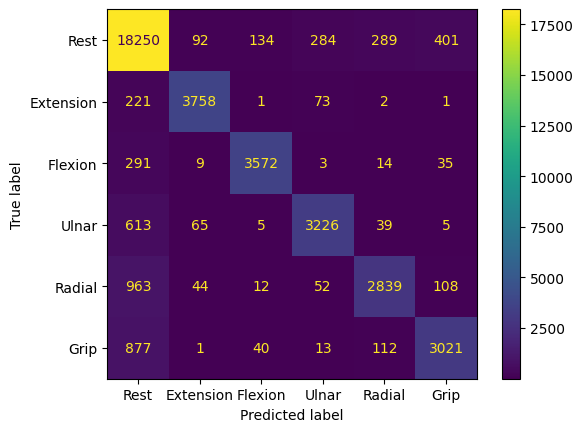

In [118]:

Confusion = confusion_matrix(Y_Test_True, y_test_predictions , labels=indexes)
print(np.shape(Confusion))
dis=ConfusionMatrixDisplay(Confusion,display_labels=("Rest","Extension","Flexion","Ulnar","Radial","Grip"))
dis.plot()
plt.show()

Quantization code follows after this. I copied Google's example for quantizing to TFLITE models.  I made changes where necessary. Link: https://ai.google.dev/edge/litert/conversion/tensorflow/quantization/post_training_quantization#full_integer_quantization_of_weights_and_activations

The first thing we need to do is change from a sequential model to functional (I couldn't edit the input while it was sequential) where we need to change the input to have a batch size of 1.  The TI compiler requires this.  It took me 2 days to figure that out.

I found similair code here https://mohanarc.substack.com/p/convert-tensorflow-models-between.  I modified part of it for my use case.

In [ ]:
temp=load_model("best_model_1dCNN_MCU.keras")
Inputs=keras.Input(shape=(600,4),batch_size=1) ####All this does is takes the layers and makes a new model but doing following the functional format.  Keeps weights.
x=Inputs
for layer in temp.layers:
    x=layer(x)
outputs=x
ModelToConvert=keras.Model(inputs=Inputs,outputs=outputs,name="quantized")
ModelToConvert.summary()

W0000 00:00:1765382036.143489  587294 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765382036.180180  587294 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765382036.181812  587294 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765382036.181816  587294 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765382036.184978  587294 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

Model: "quantized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (1, 600, 4)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (1, 299, 24)           │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (1, 149, 24)           │         1,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (1, 74, 28)            │         2,044 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_18            │ (1, 37, 28)            │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (1, 18, 80)            │         6,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_19            │ (1, 6, 80)             │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (1, 6, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (1, 480)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 6)                 │         2,886 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,794 (53.88 KB)

 Trainable params: 13,794 (53.88 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
tfmodel=tf.lite.TFLiteConverter.from_keras_model(ModelToConvert)


We need a small sample for a representive amount for our dataset.  10k is enough for this purpose.

In [ ]:
data=np.float32(X[0:10000])   ###This conversion is needed for whatever reason throws an error otherwise

This is verbatim copied from the example with a different naming scheme.

In [15]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(data).batch(1).take(100):
    yield [(input_value)]

tfmodel.optimizations = [tf.lite.Optimize.DEFAULT]
tfmodel.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
#tfmodel.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8,tf.lite.OpsSet.TFLITE_BUILTINS]
tfmodel.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
tfmodel.inference_input_type = tf.uint8
tfmodel.inference_output_type = tf.uint8

tflite_model_quant = tfmodel.convert()

INFO:tensorflow:Assets written to: /tmp/tmper2z1s8s/assets


INFO:tensorflow:Assets written to: /tmp/tmper2z1s8s/assets


Saved artifact at '/tmp/tmper2z1s8s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 600, 4), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
Captures:
  124882698562320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698564048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698564432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698563472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698562128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698562704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698565968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698567504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698566160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124882698567120: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/timothy/Documents/VSCode_Workspace/env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:846: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1765382128.157070  587294 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765382128.157080  587294 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1765382128.157388  587294 reader.cc:83] Reading SavedModel from: /tmp/tmper2z1s8s
I0000 00:00:1765382128.157698  587294 reader.cc:52] Reading meta graph with tags { serve }
I0000 00:00:1765382128.157703  587294 reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmper2z1s8s
I0000 00:00:1765382128.161286  587294 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
I0000 00:00:1765382128.161739  587294 loader.cc:236] Restoring SavedModel bundle.
I0000 00:00:1765382128.181216  587294 loader.cc:220] Running initializ

Save the model also from Google's example minus the name changes.

In [16]:
import pathlib
Outputmodel=pathlib.Path("./outputmodels")
Outputmodel.mkdir(exist_ok=True,parents=True)

tflite_model_quant_file = Outputmodel/"EMG_Model_Quantizied.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

23960

These helper functions can tell us the accuracy of our model.  The original example was using images, but I had to make slight modifications to it.  I renamed some things and had to change the dimensions of a couple of things.

In [17]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, size):
  global X_Test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(size),), dtype=int)
  for i, test_index in enumerate(size):
    Test_Window = X_Test[test_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      Test_Window = Test_Window / input_scale + input_zero_point

    Test_Window = np.expand_dims(Test_Window, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], Test_Window)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [18]:
def evaluate_model(tflite_file, model_type):
  global X_Test
  global Y_Test
  size = range(X_Test.shape[0])
  predictions = run_tflite_model(tflite_file, size)

  accuracy = (np.sum(np.argmax(Y_Test,axis=1)== predictions) * 100) / len(X_Test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(X_Test)))

In [20]:
evaluate_model("./outputmodels/EMG_Model_Quantizied.tflite", model_type="Quantized")

Quantized model accuracy is 86.0788% (Number of test samples=39465)


I ran this in another file and it returned 86.43%.  As well (same seed as well; could of done something when I copied it into this file).

This is almost the end, but we still have to convert this model to ONNX.   I did this in the command line with a different python environment.  tf2onnx has compatiability problems with my version of tensorflow.
To do the conversion, cd into the directory where the model is and type:
python -m tf2onnx.convert --tflite ./EMG_Model_Quantizied.tflite --output ./TFLITEONNXQUANT_MCUBest.onnx  --opset 18
After this you need to use TI's TVM compiler to get the necessary C library and .h file.  This requires an external download to some of their software.  You need their C2000Ware (and agree to not export outside the US because they're really concerned about that) and CGT software.  To do compilation I followed TI's documentation here https://software-dl.ti.com/mctools/nnc/mcu/users_guide/installing.html. I only tested with a dummy input on the actual MCU to get inference time.